# Synthetic Control: USA cities traffic

In this notebook we showcase the use of synthetic control for analysis a test.

In [1]:
# set-up
import sys, os 
from dotenv import load_dotenv
load_dotenv("../.env")
sys.path.append(os.environ.get("SRC_FOLDER"))

import pandas as pd 
from datetime import datetime, timedelta
import numpy as np 
from causalimpact import CausalImpact
import matplotlib.pyplot as plt 

from causalinf.ab.synthetic_control.core.models import FitStats

2023-10-09 14:37:02.844973: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-09 14:37:02.901850: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-09 14:37:02.901913: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-09 14:37:02.901961: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-09 14:37:02.913138: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-09 14:37:02.914157: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



# Data Explotation

In [2]:
df = pd.read_csv(os.path.join(os.environ.get("SRC_FOLDER"), "tests/fixtures/ga-visits-usa-cities.csv"))
df.head(3)

# Define treated and control units
treated_unit = "Houston"
control_units = [cc for cc in df.columns if cc not in [treated_unit, "period_start_date", "test_active"]]
step_intervention =  df[df["test_active"]==1].index.min()

# split data: pre/post test
# df = df.set_index("period_start_date")
mask_pre = df["test_active"]==0
df_pre, df_post = df.loc[mask_pre,[treated_unit]+control_units], df.loc[~mask_pre,[treated_unit]+control_units]


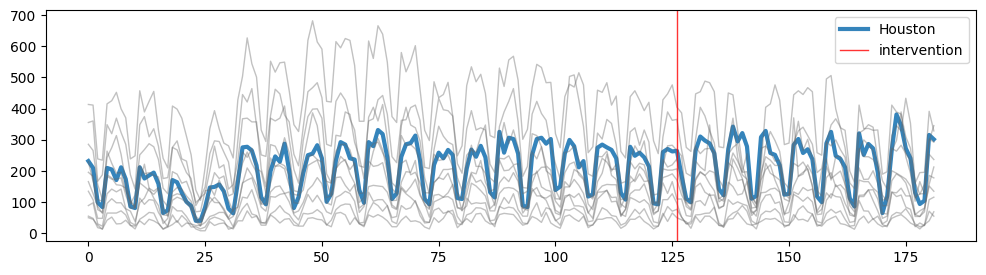

In [3]:
fig = plt.figure(figsize=(12.,3.))
Ax = fig.subplots(1,1,squeeze=False)
ax = Ax[0,0]
for col in df.columns:
    if col == treated_unit:
        ax.plot(df.index, df[col],label=col, lw=3, alpha=.9)
    elif col in control_units:
        ax.plot(df.index, df[col], lw=1, alpha=.4, color=".4")
ax.axvline( step_intervention, label="intervention", color="r", lw=1, alpha=.8)
ax.legend()
plt.show()

## Fit BSTS Model

In [4]:
fmt_dates = "%Y-%m-%d"
df["period_start_date"] = df["period_start_date"].apply(lambda x: datetime.strptime(x, fmt_dates))

In [5]:
pre_period = [ 
    df[df.test_active==0]["period_start_date"].min(), 
    df[df.test_active==0]["period_start_date"].max(), 
    ]
post_period = [
    df[df.test_active==1]["period_start_date"].min(), 
    df[df.test_active==1]["period_start_date"].max(), 
]

In [6]:
dg = df.set_index("period_start_date").drop(columns=["test_active"])
dg.index.freq = "d"

In [7]:
ci = CausalImpact(dg, pre_period, post_period, model_args={'nseasons': 7})

/home/user/libs/dst-python-causal-inference/.venv/lib/python3.10/site-packages/causalimpact/data.py:263: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data.applymap(np.isreal).values.all():


Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


In [8]:
import sklearn.metrics

error_vector = (df_pre[treated_unit].values -
    ci.inferences[:step_intervention]["complete_preds_means"].values)

fit_stats = FitStats()
fit_stats.add(
    r2 = sklearn.metrics.r2_score(
        df_pre[treated_unit].values,
        ci.inferences[:step_intervention]["complete_preds_means"].values,
    ),
    error_mean = error_vector.mean(),
    error_std = error_vector.std(),
    mse = sklearn.metrics.mean_squared_error(
        df_pre[treated_unit].values,
        ci.inferences[:step_intervention]["complete_preds_means"].values,
    )
)
fit_stats.add(rmse = np.sqrt(fit_stats.mse))
print(fit_stats)

error_mean: 6.121
error_std: 25.734
r2: 0.886
mse: 699.718
rmse: 26.452



## Inference

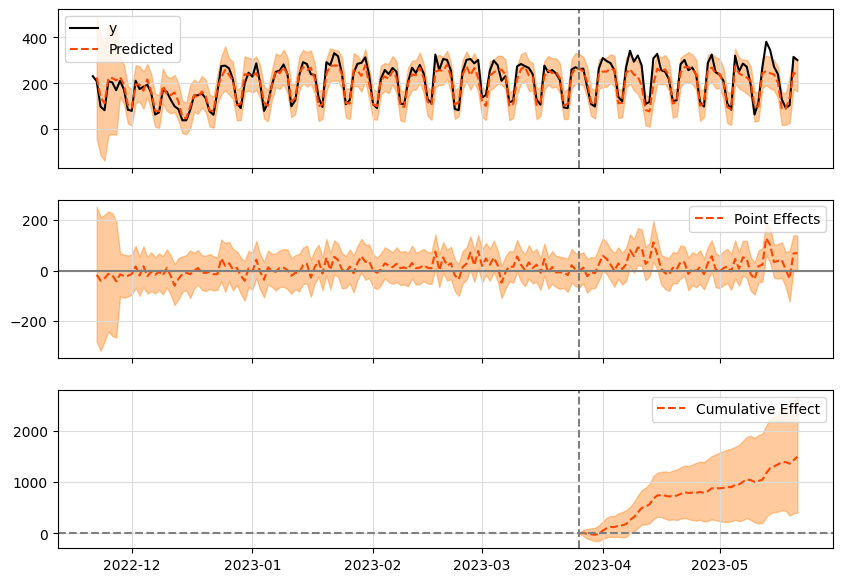

In [9]:
ci.plot()

In [10]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    226.86             12704.0
Prediction (s.d.)         200.1 (9.72)       11205.77 (544.53)
95% CI                    [180.19, 218.31]   [10090.59, 12225.1]

Absolute effect (s.d.)    26.75 (9.72)       1498.23 (544.53)
95% CI                    [8.55, 46.67]      [478.9, 2613.41]

Relative effect (s.d.)    13.37% (4.86%)     13.37% (4.86%)
95% CI                    [4.27%, 23.32%]    [4.27%, 23.32%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.8%

For more details run the command: print(impact.summary('report'))


In [11]:
ci.summary_data

,average,cumulative
actual,226.857147,12704.000000
predicted,200.103012,11205.768555
predicted_lower,180.189044,10090.586328
predicted_upper,218.305308,12225.096899
abs_effect,26.754135,1498.231445
abs_effect_lower,8.551839,478.903101
abs_effect_upper,46.668103,2613.413672
rel_effect,0.133702,0.133702
rel_effect_lower,0.042737,0.042737
rel_effect_upper,0.233220,0.233220
